In [13]:
%load_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

from espnet2.tasks.mlm import MLMTask
from espnet2.tasks.tts import TTSTask
from parallel_wavegan.utils import download_pretrained_model
from pathlib import Path
from espnet2.train.dataset import ESPnetDataset
from espnet2.tts.feats_extract.log_mel_fbank import LogMelFbank

import torch
import soundfile
import tgt
import os
import string
import math
import numpy as np
from tqdm import tqdm
from espnet2.fileio.read_text import read_2column_text,load_num_sequence_text
from espnet.nets.pytorch_backend.nets_utils import make_non_pad_mask, pad_list

import IPython.display as ipd
            
def load_vocoder(vocoder_tag="parallel_wavegan/libritts_parallel_wavegan.v1"):
    vocoder_tag = vocoder_tag.replace("parallel_wavegan/", "")
    vocoder_file = download_pretrained_model(vocoder_tag)
    vocoder_config = Path(vocoder_file).parent / "config.yml"


    vocoder = TTSTask.build_vocoder_from_file(
                    vocoder_config, vocoder_file, None, 'cpu'
                )
    return vocoder
def load_mlm_model(config_path, model_path):
    mlm_model, args = MLMTask.build_model_from_file(config_file=config_path,
                                 model_file=model_path)
    return mlm_model, args

def load_model(model_name):
    config_path='{PATH2thisproject}/a3t/egs2/an4/sedit/exp/{}/config.yaml'.format(model_name)
    model_path = '{PATH2thisproject}/a3t/egs2/an4/sedit/exp/{}/valid.loss.ave_10best.pth'.format(model_name)
    if not os.path.exists(model_path):
        model_path = '{PATH2thisproject}/a3t/egs2/an4/sedit/exp/{}/valid.loss.best.pth'.format(model_name)
    return load_mlm_model(config_path, model_path)
def get_align_data(uid,prefix):
    mfa_path = prefix+"mfa_"
    mfa_text = read_2column_text(mfa_path+'text')[uid]
    mfa_start = load_num_sequence_text(mfa_path+'start',loader_type='text_float')[uid]
    mfa_end = load_num_sequence_text(mfa_path+'end',loader_type='text_float')[uid]
    mfa_wav_path = read_2column_text(mfa_path+'wav.scp')[uid]
    return mfa_text, mfa_start, mfa_end, mfa_wav_path
def get_text_and_wav(uid,prefix='dump/raw/dev-clean/'):
    wav_path = read_2column_text(prefix+'wav.scp')[uid]
    text = read_2column_text(prefix+'text')[uid]
    wav_org, rate = soundfile.read(
                wav_path, always_2d=False)
    return text, wav_org
def get_mel_span(uid, model_name,prefix):
    mlm_model,args = load_model(model_name)
    mfa_text, mfa_start, mfa_end, mfa_wav_path = get_align_data(uid,prefix)
    align_start=torch.tensor(mfa_start).unsqueeze(0)
    align_end =torch.tensor(mfa_end).unsqueeze(0)
    align_start = torch.floor(mlm_model.feats_extract.fs*align_start/mlm_model.feats_extract.hop_length).int()
    align_end = torch.floor(mlm_model.feats_extract.fs*align_end/mlm_model.feats_extract.hop_length).int()
    return align_start[0].tolist(), align_end[0].tolist(),mfa_text
def prepare_features(uid,prefix, mlm_model,processor,old_str,new_str=None, span_boundary=None):
    mfa_text, mfa_start, mfa_end, mfa_wav_path = get_align_data(uid,prefix)
    if new_str is not None:
        mfa_text = mfa_text.replace(old_str,new_str)
    wav_org, rate = soundfile.read(
                mfa_wav_path, always_2d=False)
    
    speech = torch.tensor(wav_org,dtype=torch.float).unsqueeze(0)
    speech_lengths = torch.tensor(len(wav_org)).unsqueeze(0)
    align_start=torch.tensor(mfa_start).unsqueeze(0)
    align_start_lengths = torch.tensor(align_start.shape[1]).unsqueeze(0)
    align_end =torch.tensor(mfa_end).unsqueeze(0)
    align_end_lengths = torch.tensor(align_end.shape[1]).unsqueeze(0)
    text = torch.tensor(processor(uid=uid, data={'text':mfa_text})['text']).unsqueeze(0)
    text_lengths = torch.tensor(text.shape[1]).unsqueeze(0)
    batch = dict(
        speech=speech,
        speech_lengths=speech_lengths,
        text=text,
        text_lengths=text_lengths,
        align_start=align_start, 
        align_end=align_end, 
        align_start_lengths=align_start_lengths,
        span_boundary=span_boundary
    )
    return batch

def get_mlm_output(uid, prefix,model_name, old_str, new_str=None,decoder=False,use_teacher_forcing=False,span_boundary=[]):

    mlm_model,train_args = load_model(model_name)
    processor = MLMTask.build_preprocess_fn(train_args, False)
    
    batch = prepare_features(uid, prefix,mlm_model,processor,old_str,new_str,span_boundary)
    # wav_len * 80
    rtn = mlm_model.inference(**batch,use_teacher_forcing=use_teacher_forcing)
    output = rtn['feat_gen'] 
    output_feat = torch.cat([output[0].squeeze()]+ output[1:-1]+[output[-1].squeeze()], dim=0).cpu()
    
    
    input_feat, feats_lengths = mlm_model.feats_extract(batch['speech'], batch['speech_lengths'])
    
    return input_feat.squeeze(), output_feat, span_boundary
    

def plot_data(data, figsize=(16, 4), span_boundary=None, titles=None):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        if span_boundary:
            for x in span_boundary:
                axes[i].axvline(x=x,color='red')
        if titles is not None:
            axes[i].title.set_text(titles[i])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
vocoder = load_vocoder()

In [ ]:
model_name = "fsp_mlm0.4_phn8_new"

In [29]:
uid = "1272_128104_000003_000001"
prefix='dump/raw/dev-clean/'
text, wav_org = get_text_and_wav(uid,prefix)
print(text)
start, end, phns =  get_mel_span(uid, model_name, prefix)
print(phns)

mr Quilter is entirely free from affectation of any kind.
M IH1 S T ER0 K W IH1 L T ER0 AH0 Z EH0 N T AY1 ER0 L IY0 F R IY1 F ER0 M AE2 F EH0 K T EY1 SH AH0 N AH0 V EH1 N IY0 K AY1 N D sp


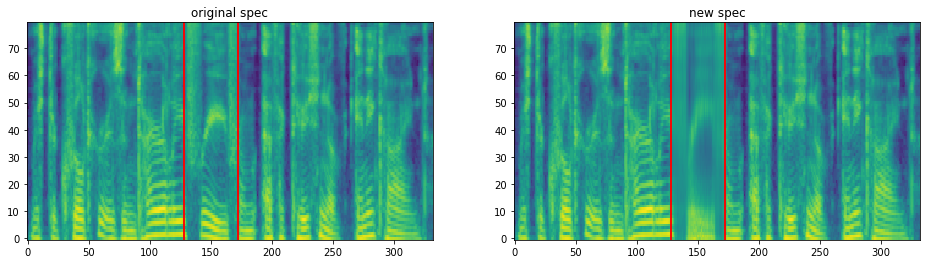

In [20]:
old_str = 'F R IY1'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

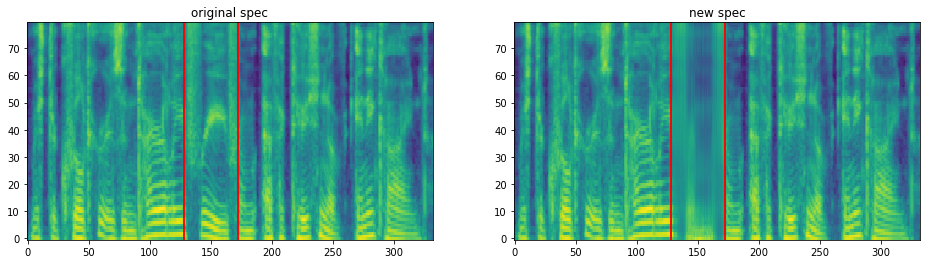

In [34]:
old_str = 'F R IY1'
new_str = 'F ER0 M'
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

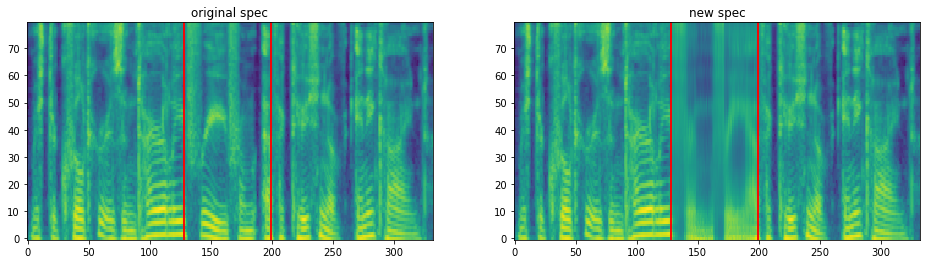

In [33]:
old_str = 'F R IY1 F ER0 M'
new_str = 'F ER0 M F R IY1'
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

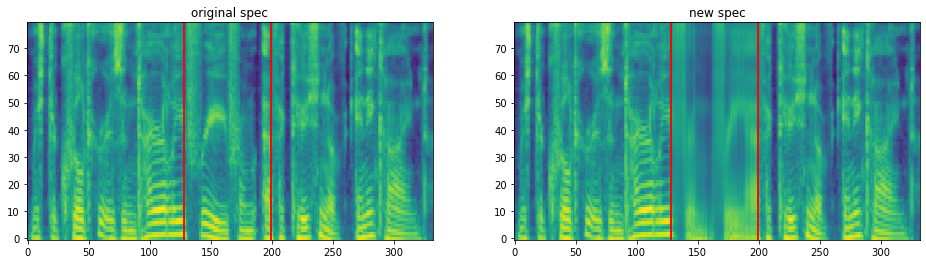

In [36]:
old_str = 'F R IY1 F ER0 M'
new_str = 'F ER0 M F R IY1'
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

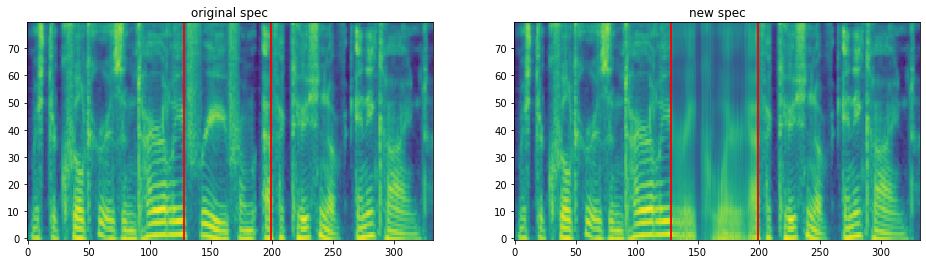

In [35]:
old_str = 'F R IY1 F ER0 M'
new_str = 'R IH0 K W AY1 ER0'
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

In [ ]:
old_str = 'M IH1 S T ER0 K W IH1 L T ER0'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

# Train Data

In [23]:
uid = "1053_289242_000051_000001"
prefix='dump/raw/train-clean-460/'
text, wav_org = get_text_and_wav(uid,prefix)
print(text)
start, end, phns =  get_mel_span(uid, model_name, prefix)
print(phns)

You will excite your blood, and that would produce an appetite it would require a million a day to satisfy.
Y UW1 W AH0 L IH0 K S AY1 T Y UH1 R B L AH1 D sp AE1 N D DH AE1 T W UH1 D P R AH0 D UW1 S AE1 N AE1 P AH0 T AY2 T IH1 T W UH1 D R IH0 K W AY1 ER0 AH0 M IH1 L Y AH0 N AH0 D EY1 T AH0 S AE1 T AH0 S F AY2 sp


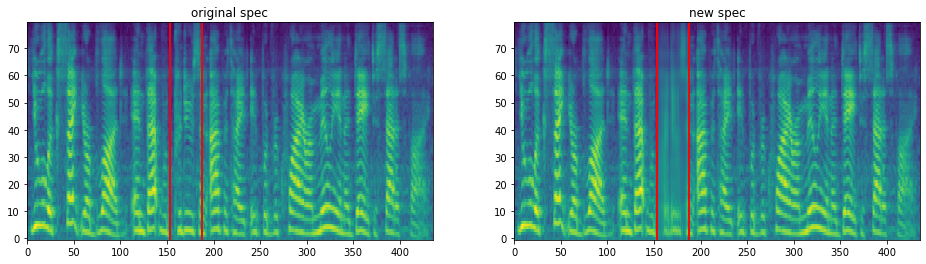

In [27]:
old_str = 'P R AH0 D UW1 S'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())

input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])


replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

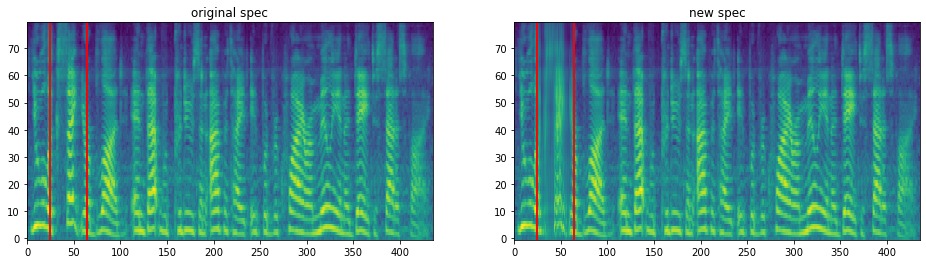

In [47]:
old_str = 'IH0 K S AY1 T Y'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])
replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

# Test Data

In [20]:
# dec_seg
model_name = "dec_seg"
uid = "1272_128104_000003_000001"
prefix='dump/raw/dev-clean/'
text, wav_org = get_text_and_wav(uid,prefix)
print(text)
start, end, phns =  get_mel_span(uid, model_name)
print(phns)

mr Quilter is entirely free from affectation of any kind.
M IH1 S T ER0 K W IH1 L T ER0 AH0 Z EH0 N T AY1 ER0 L IY0 F R IY1 F ER0 M AE2 F EH0 K T EY1 SH AH0 N AH0 V EH1 N IY0 K AY1 N D sp


## token mask

Teacher forcing True

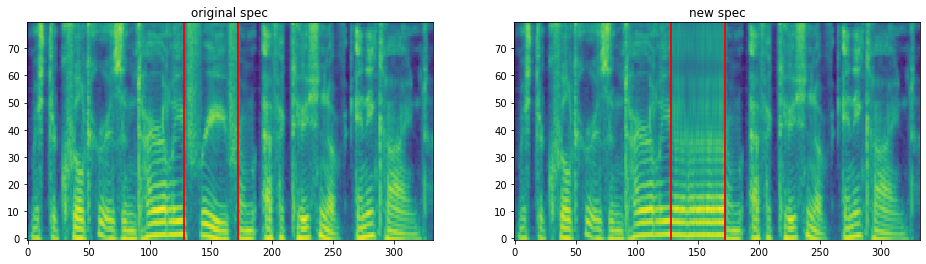

In [25]:
old_str = 'F R IY1'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=False,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])

In [27]:
# original_wav = vocoder(input_feat)
replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

Teacher forcing False

/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


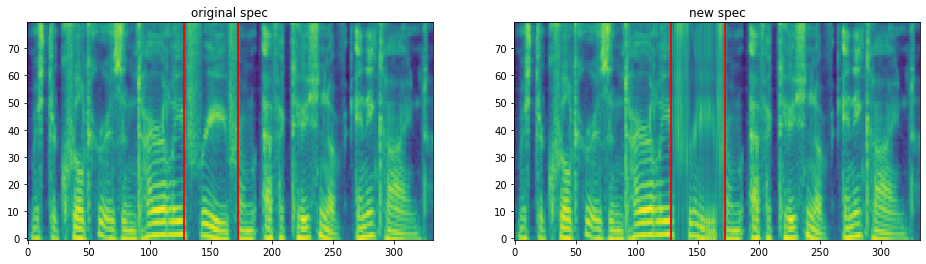

In [31]:
old_str = 'F R IY1'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])

In [32]:
# original_wav = vocoder(input_feat)
replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

## token replaced

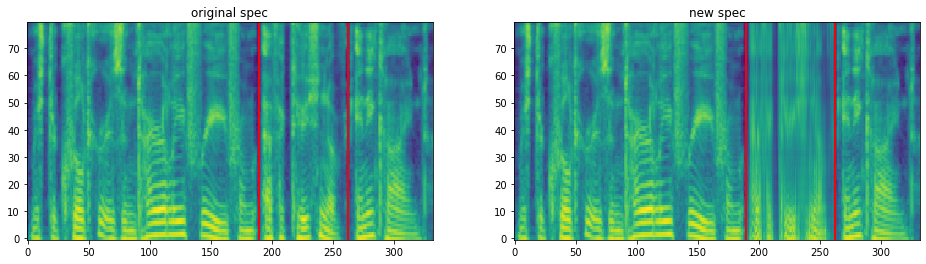

In [92]:
old_str = 'AE2 F EH0 K T EY1 SH AH0 N'
new_str = 'R EH1 K L AH0 S N AH0 S'
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, model_name,old_str,new_str, span_boundary=[start[span_0], end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])

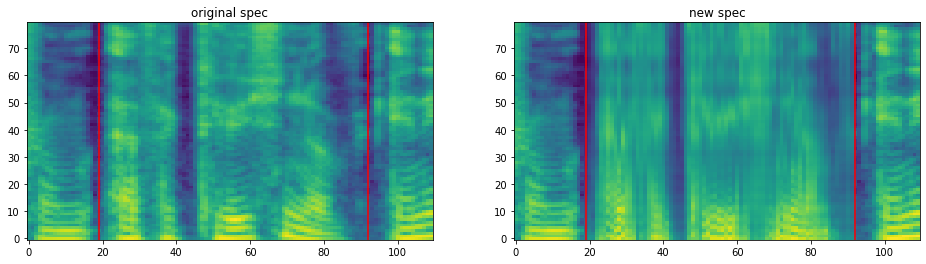

In [93]:
offset=[170,280]
span_boundary = [span_boundary[0]-offset[0], span_boundary[1]-offset[0]]
plot_data((input_feat.float().data.cpu().numpy()[offset[0]:offset[1]].T,
          output_feat.float().data.cpu().numpy()[offset[0]:offset[1]].T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])

In [94]:
replaced_wav = vocoder(output_feat)
ipd.Audio(replaced_wav.detach().float().data.cpu().numpy(), rate=24000)

In [4]:
# dec_seg
model_name = "dec_seg_span4_0.25_st8"
uid = "1272_128104_000003_000001"
prefix='dump/raw/dev-clean/'
text, wav_org = get_text_and_wav(uid,prefix)
print(text)
start, end, phns =  get_mel_span(uid, model_name,prefix)
print(phns)


mr Quilter is entirely free from affectation of any kind.


/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


M IH1 S T ER0 K W IH1 L T ER0 AH0 Z EH0 N T AY1 ER0 L IY0 F R IY1 F ER0 M AE2 F EH0 K T EY1 SH AH0 N AH0 V EH1 N IY0 K AY1 N D sp


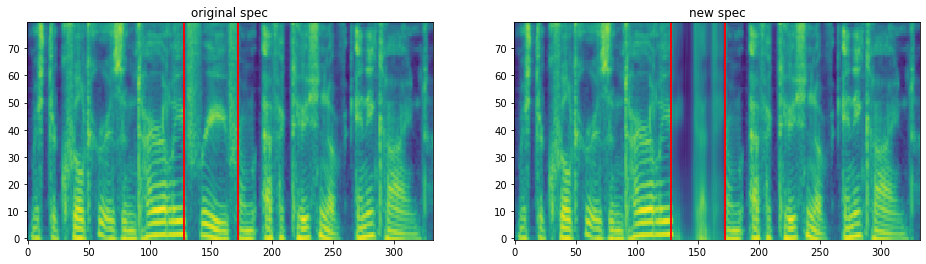

In [19]:
old_str = 'F R IY1'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=False,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])

/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


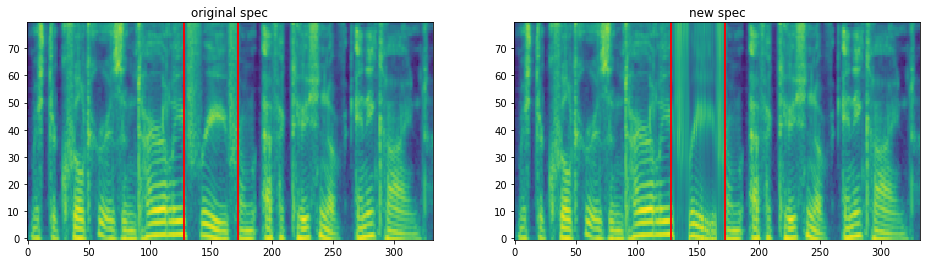

In [12]:
old_str = 'F R IY1'
new_str = None
span_0 = phns.find(old_str)
span_1 = phns.find(old_str)+len(old_str)
span_0 = len(phns[:span_0].split())
span_1 = len(phns[:span_1].split())


input_feat, output_feat, span_boundary = get_mlm_output(uid, 
                                                        prefix,
                                                        model_name,
                                                        old_str,
                                                        new_str, 
                                                        use_teacher_forcing=True,
                                                        span_boundary=[start[span_0],end[span_1]])

plot_data((input_feat.float().data.cpu().numpy().T,
          output_feat.float().data.cpu().numpy().T),
          span_boundary=span_boundary,
         titles=['original spec', 'new spec'])